### Model Development ###

Up to this point our efforts have been focused on the selection of training pairs or correspondences. These pairs consist of locations of pixels that are in the shade, and associated pixel lists that *may* be the same surface type, but are out in the open. Using the spectral information of the pixels in the open, we develop a model aimed at learning the local radiance attenuation.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from hyperspectral import *
import pandas as pd
import numpy as np
import pickle

correspondences = pickle.load(open('data/training_correspondences.p', 'rb'))

hsi_import = np.load('data/hsi_data.npz')
hsi_data = hsi_import['hyperspectral_data']
wavelengths = hsi_import['wavelengths']

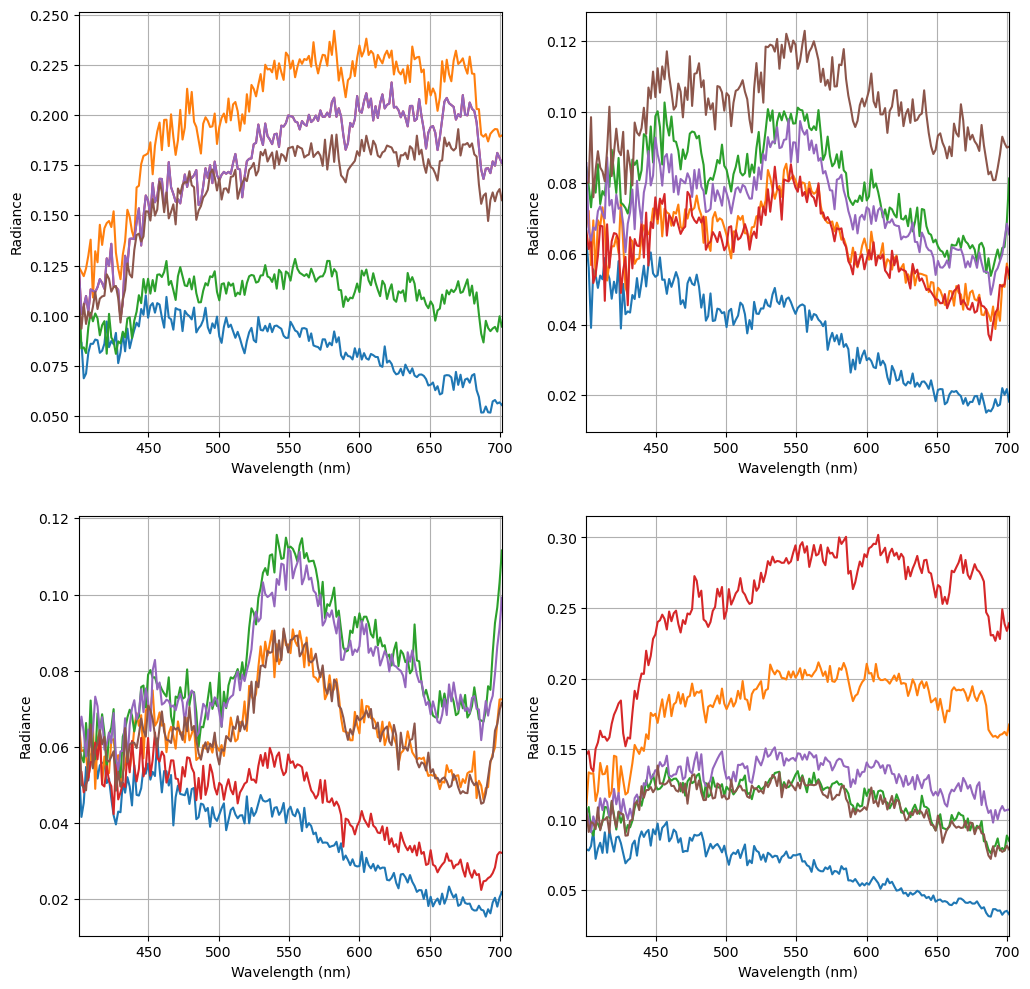

In [28]:
plt.figure(figsize=(12,12))
keys = list(correspondences.keys())
for plot in [ 221, 222, 223, 224 ]:
    key = keys[np.random.randint(0,len(keys))]
    spectra = [ get_spectrum(hsi_data, key) ]
    for px in correspondences[key]:
        spectra.append(get_spectrum(hsi_data, px))

    plt.subplot(plot)
    spectra_plot(wavelengths, np.array(spectra))
plt.show()

### Rough Draft Model v1 ###

Select open pixel per correspondence based on maximum spectrum norm. Transform HSI data matrix to reduced space. Learn kernel ridge regression model and evaluate.

In [10]:
hsi_data_matrix = multispectral_raster_to_matrix(hsi_data)
image_width = hsi_data.shape[1]

training_indices = []
testing_indices = []

for pixel in correspondences:
    training_indices.append(pixel[0] * image_width + pixel[1])
    open_norms = [ np.linalg.norm(get_spectrum(hsi_data, px)) for px in correspondences[pixel] ]
    max_norm_pixel = correspondences[pixel][np.argmax(open_norms)]
    testing_indices.append(max_norm_pixel[0] * image_width + max_norm_pixel[1])
    

In [27]:
from pca import principal_components
pc = principal_components(hsi_data_matrix)
reduced_data_matrix = pc.reduce_dimension(hsi_data_matrix, 12)
training_data = reduced_data_matrix[training_indices,:]
testing_data = reduced_data_matrix[testing_indices,:]

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

parameters = { 'alpha': [ 0.75, 1.0, 1.25 ], 'gamma': [ 0.1, 0.25, 0.5 ], 'kernel' : ['rbf', 'rbf', 'rbf'] }
model = GridSearchCV(KernelRidge(), parameters, scoring='neg_mean_squared_error', cv=10)
model.fit(training_data, testing_data)
model_results = pd.DataFrame(model.cv_results_)

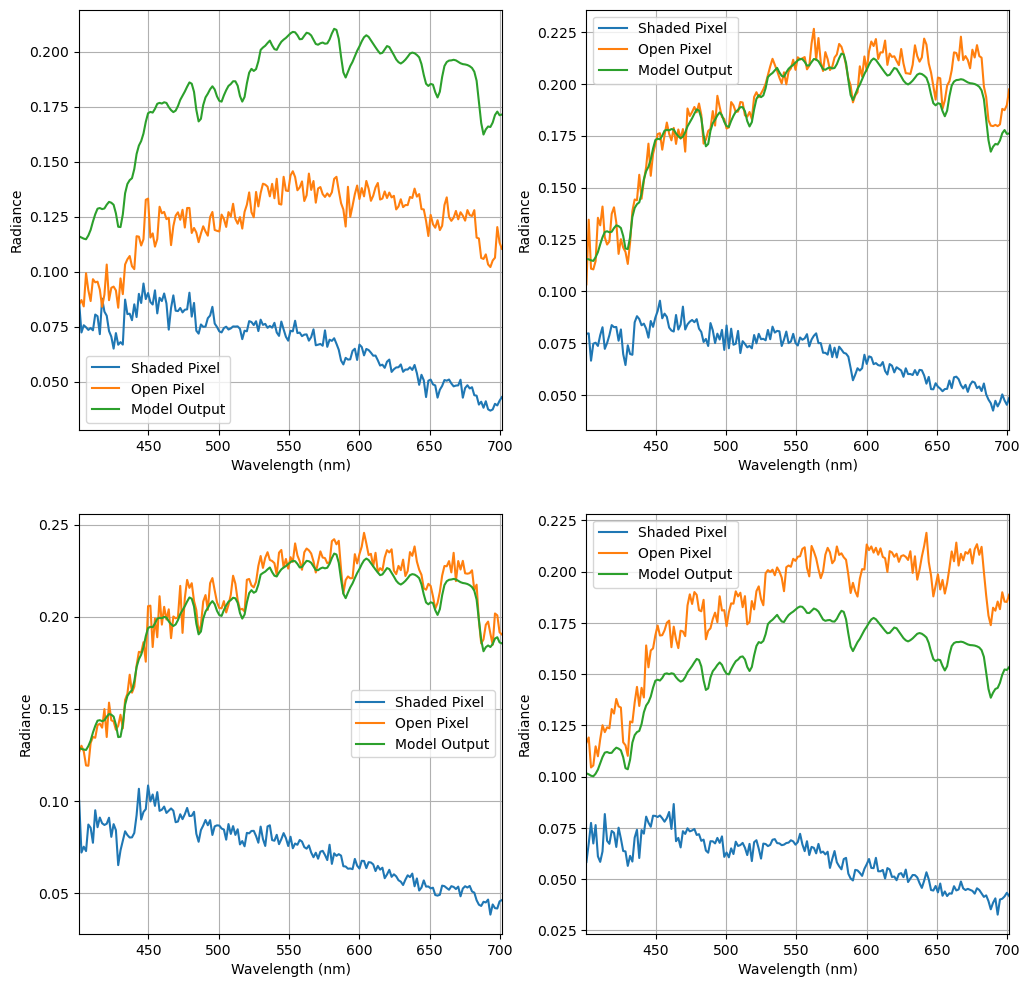

In [43]:
reduced_space_predictions = model.predict(training_data)
reconstructed_predictions = pc.reconstruct(reduced_space_predictions)

plt.figure(figsize=(12,12))
for plot in [ 221, 222, 223, 224 ]:
    
    sample_index = np.random.randint(0, len(training_indices))
    spectra = [ 
        hsi_data_matrix[training_indices[sample_index]],
        hsi_data_matrix[testing_indices[sample_index]],
        reconstructed_predictions[sample_index] 
    ]

    plt.subplot(plot)
    spectra_plot(wavelengths, np.array(spectra), legend_labels=['Shaded Pixel', 'Open Pixel', 'Model Output'])
plt.show()